In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download qramkrishna/corn-leaf-infection-dataset

100% 13.0G/13.0G [04:42<00:00, 52.8MB/s]
100% 13.0G/13.0G [04:42<00:00, 49.4MB/s]


In [ ]:
!unzip corn-leaf-infection-dataset.zip
!rm corn-leaf-infection-dataset.zip

Archive:  corn-leaf-infection-dataset.zip
  inflating: Annotation-export.csv   
  inflating: Corn Disease detection/Healthy corn/20200610_063438.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063444.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063447.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063449.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063456.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063507.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063514.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063522.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063528.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063534.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063539.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063541.jpg  
  inflating: Corn Disease detection/Healthy corn/20200610_063656.jpg

In [ ]:
!ls Corn\ Disease\ detection

'Healthy corn'	 Infected


In [ ]:
import torch
import pandas as pd
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
BATCH_SIZE = 64
CROP_SIZE = 224

transform = transforms.Compose([
    transforms.RandomResizedCrop(CROP_SIZE, scale=(0.7, 1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = ImageFolder('/content/Corn Disease detection/', transform=transform)

In [ ]:
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3168
633
424


In [ ]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
classes = ['Healthy corn', 'Infected']

In [ ]:
feature, target = next(iter(trainloader))
print(feature.shape)
type(feature)

torch.Size([64, 3, 224, 224])


torch.Tensor

In [ ]:
from torchvision.models import mobilenet_v3_large

class CornLeafClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_large(pretrained=True)
        self.freeze()
        self.mobilenet.classifier = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        return self.mobilenet(x)
    
    def freeze(self):
        for param in self.mobilenet.parameters():
            param.requires_grad = False
        
    def unfreeze(self):
        for param in self.mobilenet.parameters():
            param.requires_grad = True

In [ ]:
model = CornLeafClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
model

CornLeafClassifier(
  (mobilenet): MobileNetV3(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivati

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
from tqdm.auto import tqdm

def loop_function(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()

    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [ ]:
epochs = 20
save_epoch = []
train_cost, val_cost = [], []
train_acc, val_acc = [], []
for i in range(epochs):
    cost_train, acc_train = loop_function("train", train_dataset, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost_train)
    train_acc.append(acc_train)
    with torch.no_grad():
        cost_val, acc_val = loop_function("val", val_dataset, validationloader, model, criterion, optimizer, device)
        val_cost.append(cost_val)
        val_acc.append(acc_val)
    save_epoch.append(i+1)
    scheduler.step()

    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | val_cost: {val_cost[-1]:.4f} | "
          f"train_acc: {train_acc[-1]:.4f} | val_acc: {val_acc[-1]:.4f} | Learning Rate: {scheduler.get_last_lr()}")

Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/20 | train_cost: 0.2802 | val_cost: 0.1081 | train_acc: 0.8924 | val_acc: 0.9589 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/20 | train_cost: 0.1349 | val_cost: 0.0795 | train_acc: 0.9470 | val_acc: 0.9652 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/20 | train_cost: 0.1562 | val_cost: 0.1256 | train_acc: 0.9356 | val_acc: 0.9510 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/20 | train_cost: 0.1019 | val_cost: 0.0893 | train_acc: 0.9609 | val_acc: 0.9700 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/20 | train_cost: 0.0684 | val_cost: 0.1026 | train_acc: 0.9747 | val_acc: 0.9684 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/20 | train_cost: 0.0676 | val_cost: 0.0640 | train_acc: 0.9747 | val_acc: 0.9795 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/20 | train_cost: 0.0542 | val_cost: 0.1095 | train_acc: 0.9785 | val_acc: 0.9589 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/20 | train_cost: 0.0662 | val_cost: 0.0743 | train_acc: 0.9744 | val_acc: 0.9668 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/20 | train_cost: 0.0547 | val_cost: 0.0725 | train_acc: 0.9766 | val_acc: 0.9700 | Learning Rate: [0.001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/20 | train_cost: 0.0544 | val_cost: 0.2424 | train_acc: 0.9801 | val_acc: 0.9163 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/20 | train_cost: 0.0725 | val_cost: 0.0630 | train_acc: 0.9747 | val_acc: 0.9763 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/20 | train_cost: 0.0260 | val_cost: 0.0521 | train_acc: 0.9927 | val_acc: 0.9810 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/20 | train_cost: 0.0265 | val_cost: 0.0481 | train_acc: 0.9905 | val_acc: 0.9810 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/20 | train_cost: 0.0240 | val_cost: 0.0492 | train_acc: 0.9915 | val_acc: 0.9826 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/20 | train_cost: 0.0236 | val_cost: 0.0380 | train_acc: 0.9905 | val_acc: 0.9810 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/20 | train_cost: 0.0221 | val_cost: 0.0548 | train_acc: 0.9927 | val_acc: 0.9826 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/20 | train_cost: 0.0221 | val_cost: 0.0604 | train_acc: 0.9924 | val_acc: 0.9795 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/20 | train_cost: 0.0389 | val_cost: 0.0739 | train_acc: 0.9861 | val_acc: 0.9779 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/20 | train_cost: 0.0240 | val_cost: 0.0397 | train_acc: 0.9902 | val_acc: 0.9842 | Learning Rate: [0.0001]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/20 | train_cost: 0.0242 | val_cost: 0.0475 | train_acc: 0.9918 | val_acc: 0.9826 | Learning Rate: [1e-05]


In [ ]:
torch.save({
    "epoch": i,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": criterion,
    "scheduler": scheduler.state_dict() 
}, "model_checkpoint.pth")

torch.save(model.state_dict(), "model_save.pth")

In [ ]:
from pandas import DataFrame

#save loss
cost_graph = [save_epoch, train_cost, val_cost]
loss = DataFrame(cost_graph).transpose()
loss.columns=['epoch','train_cost','val_cost']
loss.to_csv('sch_loss_history_epoch_1-35.csv')

#save accuracy
acc_graph = [save_epoch, train_acc, val_acc]
accuracy = DataFrame(acc_graph).transpose()
accuracy.columns=['epoch','train_acc','val_acc']
accuracy.to_csv('sch_acc_history_epoch_1-35.csv')

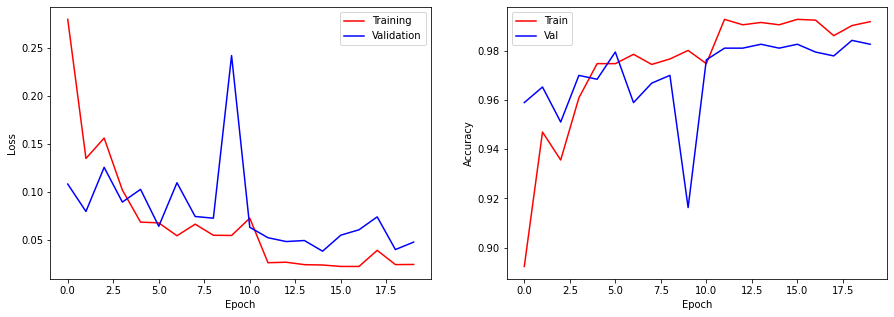

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label='Training')
plt.plot(val_cost, 'b-', label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(122)
plt.plot(train_acc, 'r-', label='Train')
plt.plot(val_acc, 'b-', label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp model_save.pth model_checkpoint.pth sch_acc_history_epoch_1-35.csv sch_loss_history_epoch_1-35.csv /content/drive/MyDrive/corn-leaf-infection

# Check Data Test Accuracy

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            predictions = scores.argmax(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [ ]:
check_accuracy(testloader, model)

Got 418 / 424 with accuracy 98.58


# Predict and Sanity Check

In [ ]:
weights = torch.load('model_checkpoint.pth')
model.load_state_dict(weights['model_state_dict'])
model = model.to(device)

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

[classes[pred] for pred in preds]

['Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Infected',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Infected',
 'Healthy corn',
 'Healthy corn',
 'Healthy corn',
 'Infected']

In [ ]:
def convert_to_label(x):
    return [label for pred, label in zip(x, train_set.classes) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

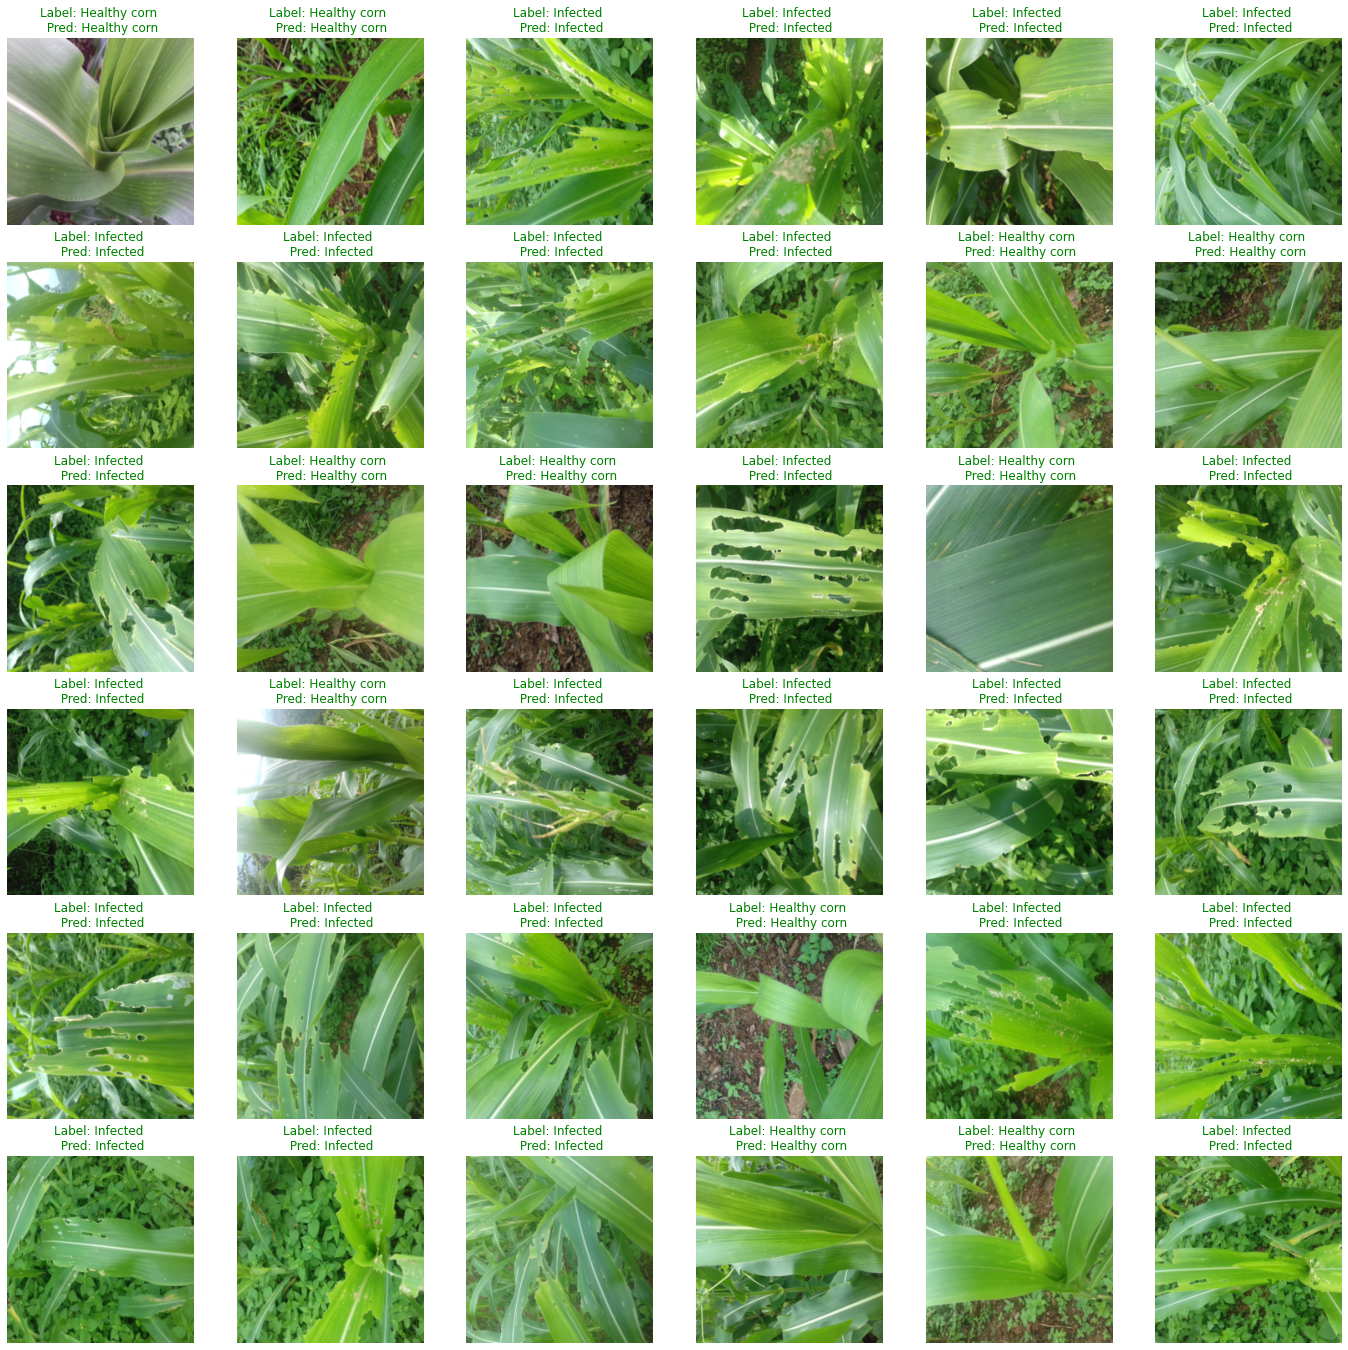

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {'color':'r'} if label != pred else {'color':'g'}
    # label, pred = convert_to_label(label), convert_to_label(pred)
    label, pred = classes[label.item()], classes[pred.item()]
    ax.set_title(f'Label: {label} \n Pred: {pred}', fontdict=font)
    ax.axis('off')